# WiFi Indoor Geolocation - Training depuis MQTT
## UVSQ SEE - Chargement Direct depuis Broker MQTT

**NOUVEAU :** Ce notebook se connecte directement au broker MQTT pour récupérer les données.

**Avantages :**
- Pas besoin de télécharger/uploader des CSV
- Données en temps réel depuis les Tab5
- Workflow simplifié
- Parfait pour collecte multi-groupes

**Configuration requise :**
- Broker MQTT accessible (HiveMQ Cloud ou public)
- Topics avec données de locations

**Output :**
- `nn_weights.json` (à déployer sur Tab5)

## Step 1: Install Libraries

In [ ]:
# Install required libraries
!pip install numpy pandas scikit-learn tensorflow matplotlib paho-mqtt -q

print("✓ Libraries installed")

✓ Libraries installed


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import paho.mqtt.client as mqtt
import time
from collections import defaultdict

## Step 2: Configuration MQTT

**Modifier selon votre broker :**

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import paho.mqtt.client as mqtt
import time
from collections import defaultdict

# ========== CONFIGURATION MQTT ==========

# Option 1: HiveMQ Cloud (TLS)
MQTT_BROKER = "2bcf898148934fe9b985e2edd298658a.s1.eu.hivemq.cloud"
MQTT_PORT = 8883
MQTT_USE_TLS = True
MQTT_USERNAME = "Asmaa"
MQTT_PASSWORD = "07121416Li"

# Option 2: Broker public (décommenter si besoin)
# MQTT_BROKER = "broker.hivemq.com"
# MQTT_PORT = 18
# MQTT_USE_TLS = False
# MQTT_USERNAME = None
# MQTT_PASSWORD = None

# Topics à écouter
TOPIC_PREFIX = "LaVilette"

# Durée d'écoute (secondes)
LISTEN_DURATION = 120  # Increased to 120 seconds to allow more time for data collection

print("Configuration MQTT:")
print(f"  Broker: {MQTT_BROKER}:{MQTT_PORT}")
print(f"  TLS: {MQTT_USE_TLS}")
print(f"  Topics: {TOPIC_PREFIX}/#")
print(f"  Listen duration: {LISTEN_DURATION}s")

Configuration MQTT:
  Broker: 2bcf898148934fe9b985e2edd298658a.s1.eu.hivemq.cloud:8883
  TLS: True
  Topics: LaVilette/#
  Listen duration: 120s


## Step 3: Connexion MQTT et Collecte des Données

**IMPORTANT :** Les Tab5 doivent avoir uploadé leurs données AVANT de lancer cette cellule.

In [ ]:
from collections import defaultdict
import json
import time
import ssl
import paho.mqtt.client as mqtt

# =========================================================
# STEP 3 — MQTT COLLECT (REAL TAB5, NO SIMULATION)
# Uses variables defined in Step 2:
#   MQTT_BROKER, MQTT_PORT, MQTT_USE_TLS
#   MQTT_USERNAME, MQTT_PASSWORD
#   TOPIC_PREFIX (ex: "LaVilette")
#   LISTEN_DURATION (seconds)
# =========================================================

# Storage
received_data = defaultdict(list)
ap_mapping = {}
message_count = 0
listening = False

# ------------------------------
# MQTT message handler
# ------------------------------
def on_message(client, userdata, msg):
    global message_count, listening

    # Ignore status/control topics (optional)
    if "status" in msg.topic or "control" in msg.topic:
        return

    if not listening:
        return

    try:
        payload = json.loads(msg.payload.decode("utf-8", errors="ignore"))

        location = payload.get("location")
        samples = payload.get("samples", [])
        ap_order = payload.get("ap_order", [])

        if not location or not isinstance(samples, list):
            return

        # Save AP mapping once
        if "macs" not in ap_mapping and ap_order:
            ap_mapping["macs"] = ap_order

        # Keep RSSI vector aligned with ap_order
        for sample in samples:
            mac_to_rssi = {ap.get("mac"): ap.get("rssi") for ap in sample.get("aps", [])}
            rssi_values = [mac_to_rssi.get(mac, -100.0) for mac in ap_order]
            received_data[location].append(rssi_values)

        message_count += 1
        total = sum(len(s) for s in received_data.values())
        print(f"✓ [{message_count}] {location}: +{len(samples)} (Total samples: {total})")

    except Exception as e:
        print(f"✗ Error decoding message on {msg.topic}: {e}")

# ------------------------------
# Connect MQTT (HiveMQ Cloud TLS)
# ------------------------------
client = mqtt.Client()
client.on_message = on_message

# Auth (HiveMQ Cloud)
client.username_pw_set(MQTT_USERNAME, MQTT_PASSWORD)

# TLS (HiveMQ Cloud)
if MQTT_USE_TLS:
    client.tls_set(cert_reqs=ssl.CERT_NONE)
    client.tls_insecure_set(True)

client.connect(MQTT_BROKER, MQTT_PORT, 60)

# Subscribe to all topics under prefix (Tab5 publishes to LaVilette/data and LaVilette/status)
topic_filter = f"{TOPIC_PREFIX}/#"
client.subscribe(topic_filter)

client.loop_start()

print("=" * 60)
print("MQTT CONNECTED")
print("=" * 60)
print(f"Broker: {MQTT_BROKER}:{MQTT_PORT} | TLS: {MQTT_USE_TLS}")
print(f"Subscribed to: {topic_filter}")
print("\n➡️ Maintenant, sur la Tab5, appuie sur le bouton ENVOYER VERS HIVEMQ.\n")

# Start listening immediately (simpler and reliable)
listening = True

# Listen for LISTEN_DURATION seconds
for i in range(LISTEN_DURATION):
    time.sleep(1)
    if (i + 1) % 10 == 0:
        total = sum(len(s) for s in received_data.values())
        print(f"⏱️ {LISTEN_DURATION-i-1}s remaining (Messages: {message_count}, Samples: {total})")

# Stop
listening = False
client.loop_stop()
client.disconnect()

# Summary
total = sum(len(s) for s in received_data.values())
print("\n" + "=" * 60)
print("COLLECTION COMPLETE")
print("=" * 60)
print(f"Total: {total} samples from {len(received_data)} locations")
for location, samples in received_data.items():
    print(f"  {location}: {len(samples)} samples")

# Optional validation
if total < 20:
    raise ValueError("Insufficient data - collect more samples")


/tmp/ipython-input-1076122186.py:65: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


MQTT CONNECTED
Broker: 2bcf898148934fe9b985e2edd298658a.s1.eu.hivemq.cloud:8883 | TLS: True
Subscribed to: LaVilette/#

➡️ Maintenant, sur la Tab5, appuie sur le bouton ENVOYER VERS HIVEMQ.

✓ [1] Zone 1: +5 (Total samples: 5)
✓ [2] Zone 1: +5 (Total samples: 10)
✓ [3] Zone 1: +5 (Total samples: 15)
✓ [4] Zone 1: +5 (Total samples: 20)
✓ [5] Zone 1: +5 (Total samples: 25)
✓ [6] Zone 1: +5 (Total samples: 30)
✓ [7] Zone 1: +5 (Total samples: 35)
✓ [8] Zone 1: +5 (Total samples: 40)
✓ [9] Zone 1: +5 (Total samples: 45)
✓ [10] Zone 1: +5 (Total samples: 50)
✓ [11] Zone 2: +5 (Total samples: 55)
✓ [12] Zone 2: +5 (Total samples: 60)
✓ [13] Zone 2: +5 (Total samples: 65)
✓ [14] Zone 2: +5 (Total samples: 70)
✓ [15] Zone 2: +5 (Total samples: 75)
✓ [16] Zone 1: +5 (Total samples: 80)
✓ [17] Zone 1: +5 (Total samples: 85)
✓ [18] Zone 1: +5 (Total samples: 90)
✓ [19] Zone 1: +5 (Total samples: 95)
✓ [20] Zone 1: +5 (Total samples: 100)
✓ [21] Zone 1: +5 (Total samples: 105)
✓ [22] Zone 1: +5 (

## Step 4: Convert MQTT Data to DataFrame

In [ ]:
# Check if we have data
if not received_data:
    raise ValueError("No data received from MQTT! Upload data from Tab5 first.")

if not ap_mapping:
    raise ValueError("No AP mapping received! Check MQTT message format.")

# Build dataset
all_samples = []
all_labels = []

for location, samples in received_data.items():
    for sample in samples:
        all_samples.append(sample)
        all_labels.append(location)

# Create DataFrame
num_aps = len(ap_mapping['macs'])
feature_columns = [f'AP_{i}' for i in range(num_aps)]

data = pd.DataFrame(all_samples, columns=feature_columns)
data['location'] = all_labels

print("=" * 60)
print("DATASET CREATED FROM MQTT")
print("=" * 60)
print(f"Total samples: {len(data)}")
print(f"Locations: {data['location'].unique()}")
print(f"Number of APs: {num_aps}")
print("\nSamples per location:")
print(data['location'].value_counts())
print("\nAP Mapping:")
for i, mac in enumerate(ap_mapping['macs']):
    print(f"  AP_{i} = {mac}")
print("=" * 60)

ValueError: No AP mapping received! Check MQTT message format.

In [ ]:
# Display first few rows
print("\nDataset preview:")
data.head(10)


Dataset preview:


,AP_0,AP_1,AP_2,AP_3,AP_4,AP_5,AP_6,AP_7,AP_8,AP_9,location
0,-100,-100,-100,-45.0,-100,-100,-100,-100,-100,-100,Zone 1
1,-100,-100,-100,-55.0,-100,-100,-100,-100,-100,-100,Zone 1
2,-100,-100,-100,-55.0,-100,-100,-100,-100,-100,-100,Zone 1
3,-100,-100,-100,-51.0,-100,-100,-100,-100,-100,-100,Zone 1
4,-100,-100,-100,-64.0,-100,-100,-100,-100,-100,-100,Zone 1
5,-100,-100,-100,-57.5,-100,-100,-100,-100,-100,-100,Zone 1
6,-100,-100,-100,-59.0,-100,-100,-100,-100,-100,-100,Zone 1
7,-100,-100,-100,-59.0,-100,-100,-100,-100,-100,-100,Zone 1
8,-100,-100,-100,-43.5,-100,-100,-100,-100,-100,-100,Zone 1
9,-100,-100,-100,-61.0,-100,-100,-100,-100,-100,-100,Zone 1


## Step 5: Prepare Data for Training

In [ ]:
# Extract features (X) and labels (y)
X = data[feature_columns].values
y = data['location'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Encode location names to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nLocation encoding:")
for i, location in enumerate(label_encoder.classes_):
    print(f"  {i}: {location}")

num_classes = len(label_encoder.classes_)

X shape: (400, 10)
y shape: (400,)

Location encoding:
  0: Zone 1
  1: Zone 2
  2: Zone 3
  3: Zone 4


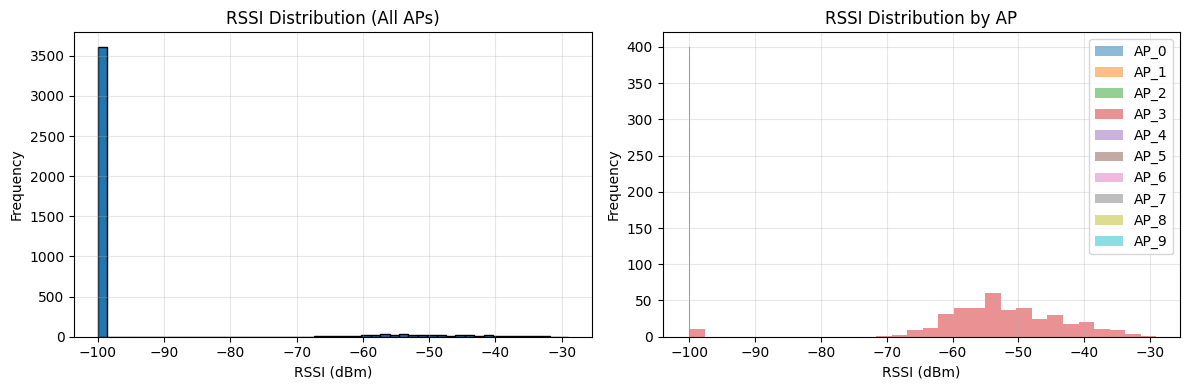

In [ ]:
# Visualize RSSI distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, edgecolor='black')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Frequency')
plt.title('RSSI Distribution (All APs)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for i in range(min(num_aps, 10)):  # Max 10 for readability
    plt.hist(X[:, i], bins=30, alpha=0.5, label=f'AP_{i}')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Frequency')
plt.title('RSSI Distribution by AP')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Split Data & Normalize

In [ ]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Calculate normalization parameters (from training data ONLY)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

print(f"\nNormalization parameters:")
print(f"Mean: {mean}")
print(f"Std: {std}")

# Normalize data
X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

print(f"\nNormalized training data range: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Training set: 320 samples
Test set: 80 samples

Normalization parameters:
Mean: [-100.       -100.       -100.        -53.109375 -100.       -100.
 -100.       -100.       -100.       -100.      ]
Std: [ 0.          0.          0.         11.61022877  0.          0.
  0.          0.          0.          0.        ]

Normalized training data range: [nan, nan]


/tmp/ipython-input-3361123477.py:18: RuntimeWarning: invalid value encountered in divide
  X_train_norm = (X_train - mean) / std
/tmp/ipython-input-3361123477.py:19: RuntimeWarning: invalid value encountered in divide
  X_test_norm = (X_test - mean) / std


## Step 7: Build Neural Network

In [ ]:
# Build model
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(num_aps,), name='hidden'),
    layers.Dense(num_classes, activation='softmax', name='output')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244 (976.00 B)

 Trainable params: 244 (976.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 8: Train the Model

In [ ]:
# Train model
history = model.fit(
    X_train_norm, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3112 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2877 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2489 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2770 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2728 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2356 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2539 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2892 - loss: nan - val_accuracy: 0.1875 - val_loss: nan
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

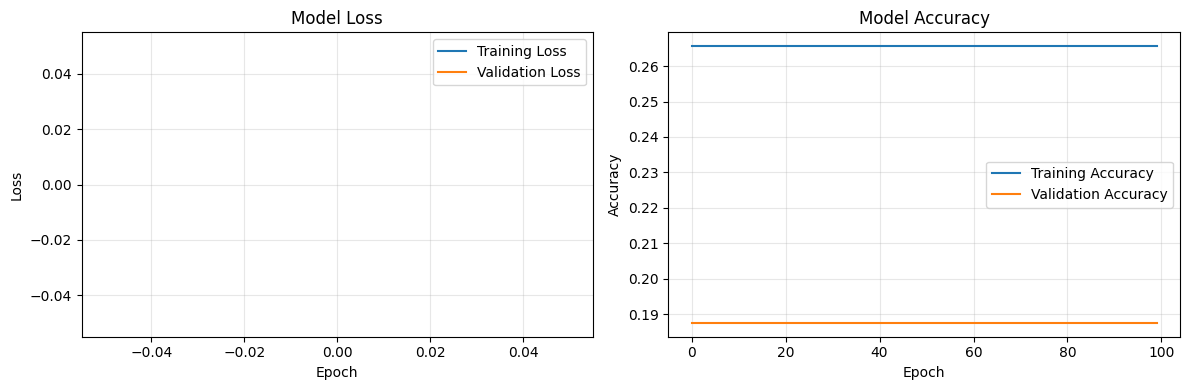

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: Evaluate Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2461 - loss: nan 


TEST ACCURACY: 25.00%
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


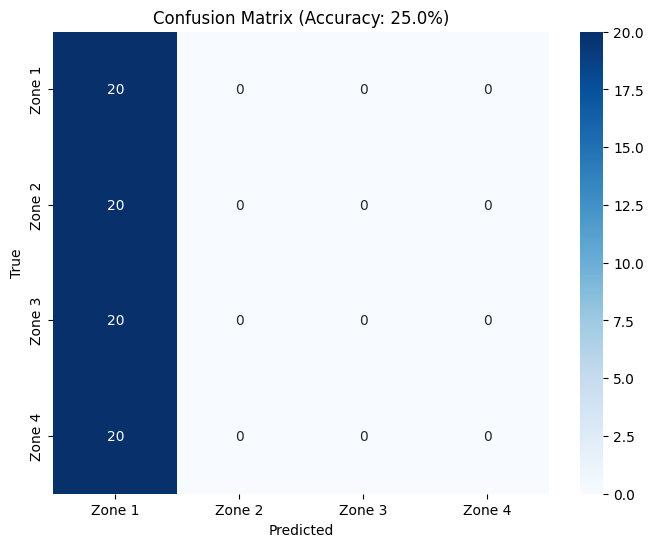


Per-location accuracy:
  Zone 1: 100.0%
  Zone 2: 0.0%
  Zone 3: 0.0%
  Zone 4: 0.0%


In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)

print("=" * 60)
print(f"TEST ACCURACY: {test_accuracy * 100:.2f}%")
print("=" * 60)

# Make predictions
y_pred = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {test_accuracy*100:.1f}%)')
plt.show()

# Per-class accuracy
print("\nPer-location accuracy:")
for i, location in enumerate(label_encoder.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred_classes[mask] == i).mean()
        print(f"  {location}: {acc*100:.1f}%")

## Step 10: Export Weights for ESP32

In [ ]:
# Extract weights and biases
hidden_layer = model.get_layer('hidden')
output_layer = model.get_layer('output')

W1, b1 = hidden_layer.get_weights()
W2, b2 = output_layer.get_weights()

print("Network weights extracted:")
print(f"  W1 shape: {W1.shape} (Input → Hidden)")
print(f"  b1 shape: {b1.shape}")
print(f"  W2 shape: {W2.shape} (Hidden → Output)")
print(f"  b2 shape: {b2.shape}")

# Create export structure
weights_dict = {
    "input_size": int(num_aps),
    "hidden_size": 16,
    "output_size": int(num_classes),

    # Network weights
    "W1": W1.tolist(),
    "b1": b1.tolist(),
    "W2": W2.tolist(),
    "b2": b2.tolist(),

    # Normalization parameters
    "mean": mean.tolist(),
    "std": std.tolist(),

    # AP mapping (CRITICAL!)
    "ap_order": ap_mapping['macs'],

    # Location names
    "locations": label_encoder.classes_.tolist(),

    # Metadata
    "accuracy": float(test_accuracy),
    "training_samples": int(len(X_train)),
    "test_samples": int(len(X_test)),
    "source": "MQTT direct"
}

# Save to JSON file
with open('nn_weights.json', 'w') as f:
    json.dump(weights_dict, f, indent=2)

print("\n✓ Weights exported to nn_weights.json")
print(f"  File size: {len(json.dumps(weights_dict))} bytes")
print("\n📌 IMPORTANT: This file includes the AP order (MAC addresses)")
print("   The museum guide will use these exact APs for inference!")

Network weights extracted:
  W1 shape: (10, 16) (Input → Hidden)
  b1 shape: (16,)
  W2 shape: (16, 4) (Hidden → Output)
  b2 shape: (4,)

✓ Weights exported to nn_weights.json
  File size: 1894 bytes

📌 IMPORTANT: This file includes the AP order (MAC addresses)
   The museum guide will use these exact APs for inference!


## Step 11: Verify Export

In [ ]:
# Load and verify the exported file
with open('nn_weights.json', 'r') as f:
    loaded = json.load(f)

print("=" * 60)
print("EXPORTED FILE VERIFICATION")
print("=" * 60)
print(f"Architecture: {loaded['input_size']} → {loaded['hidden_size']} → {loaded['output_size']}")
print(f"\nAP Order (must match collection):")
for i, mac in enumerate(loaded['ap_order']):
    print(f"  AP_{i} = {mac}")
print(f"\nLocations: {loaded['locations']}")
print(f"Accuracy: {loaded['accuracy']*100:.2f}%")
print(f"Training samples: {loaded['training_samples']}")
print(f"Test samples: {loaded['test_samples']}")
print(f"Source: {loaded['source']}")
print("=" * 60)

EXPORTED FILE VERIFICATION
Architecture: 10 → 16 → 4

AP Order (must match collection):
  AP_0 = 3E:5B:88:C7:F1:62
  AP_1 = E6:4B:83:3D:76:2E
  AP_2 = 82:9F:F5:13:4A:77
  AP_3 = 92:4A:7B:4A:09:8B
  AP_4 = CA:D4:37:18:E6:FA
  AP_5 = 2E:3A:DD:5D:02:3D
  AP_6 = D8:84:66:02:B7:49
  AP_7 = 96:85:62:D0:6D:33
  AP_8 = 06:25:45:C2:95:AC
  AP_9 = 00:00:00:00:00:00

Locations: ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4']
Accuracy: 25.00%
Training samples: 320
Test samples: 80
Source: MQTT direct


## Step 12: Download Files

In [ ]:
from google.colab import files

# Download nn_weights.json
files.download('nn_weights.json')

print("✓ Downloaded nn_weights.json")
print("\nNext steps:")
print("1. Copy nn_weights.json to SD card root")
print("2. Copy content_config.json to SD card root")
print("3. Copy images to /images/ folder on SD card")
print("4. Upload museum_guide_tab5_simple.ino to Tab5")
print("5. Test the system!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded nn_weights.json

Next steps:
1. Copy nn_weights.json to SD card root
2. Copy content_config.json to SD card root
3. Copy images to /images/ folder on SD card
4. Upload museum_guide_tab5_simple.ino to Tab5
5. Test the system!


## ✅ Avantages de Cette Méthode

**MQTT Direct vs CSV Upload:**

1. **Pas de téléchargement/upload**
   - Données viennent directement du broker
   - Gain de temps énorme

2. **Temps réel**
   - Les Tab5 uploadent → Google Colab reçoit
   - Pas d'étape intermédiaire

3. **Multi-groupes**
   - Parfait pour Cité des Sciences (4 groupes)
   - Chacun upload, Colab agrège tout

4. **Traçabilité**
   - Chaque message contient tab5_mac
   - On sait d'où viennent les données

5. **Automatisation**
   - Workflow simplifié
   - Moins d'erreurs humaines

**Workflow:**
```
Tab5 #1 → MQTT → Broker ← Google Colab
Tab5 #2 → MQTT → Broker ← (écoute 30s)
Tab5 #3 → MQTT → Broker ← (agrège tout)
Tab5 #4 → MQTT → Broker ← (→ training)
```